## Setup


In [1]:
import sklearn

In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 67.3 MB/s eta 0:00:00


You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 KB 54.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 KB 45.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 KB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 83.3 MB/s eta 0:00:00


In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_addons as tfa
from official.nlp import optimization  # to create AdamW optimizer

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

tf.get_logger().setLevel('ERROR')

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
tf.test.gpu_device_name()

'/device:GPU:0'

## **Important**: place all .pkl/.csv files in this directory: /archive
## If running without google colab, don't run these cells and load in the data manually

In [6]:
from google.colab import drive
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding
drive.mount('/content/drive')

In [8]:
%cd /content/drive/MyDrive/archive

/content/drive/MyDrive/archive


In [9]:
%ls

LUN_bert/  train_20%.pkl           training_cleaned_20e/  training_resampled_1/
model.png  train_full.pkl          training_cleaned_40e/  training_resampled_2/
test.pkl   train_full_smaller.pkl  training_cleaned_60e/  train.pkl


## Load in dataset

In [10]:
# NOTE: only one can be true!

# only syn sem data, no text
use_syn_sem = False
# uncleaned text and syn sem data
use_syn_sem_with_text = False
# cleaned text and syn sem data
use_syn_sem_with_cleaned_text = True

In [11]:
df = pd.read_pickle("train_full.pkl")

In [12]:
df.dtypes

Label                           int64
Text                           object
Text_Clean                     object
Char_Count                      int64
Word_Count                      int64
Capital_Chars_Count             int64
Capital_Words_Count             int64
First_Person_Pronoun_Count      int64
Second_Person_Pronoun_Count     int64
Third_Person_Pronoun_Count      int64
Boost_Count                     int64
Number_Count                    int64
Positive_Word_Count             int64
Negative_Word_Count             int64
Proper_Noun_Count               int64
Conjunction_Count               int64
Superlative_Count               int64
dtype: object

In [51]:
df.columns

Index(['Label', 'Text', 'Text_Clean', 'Char_Count', 'Word_Count',
       'Capital_Chars_Count', 'Capital_Words_Count',
       'First_Person_Pronoun_Count', 'Second_Person_Pronoun_Count',
       'Third_Person_Pronoun_Count', 'Boost_Count', 'Number_Count',
       'Positive_Word_Count', 'Negative_Word_Count', 'Proper_Noun_Count',
       'Conjunction_Count', 'Superlative_Count'],
      dtype='object')

## Counting the distribution across classes

In [13]:
if use_syn_sem or use_syn_sem_with_text or use_syn_sem_with_cleaned_text:
  _, class_0, class_1, class_2, class_3 = np.bincount(df['Label'])
else:
  _, class_0, class_1, class_2, class_3 = np.bincount(df['label'])

In [14]:
total = class_0 + class_1 + class_2 + class_3
print('Examples:\n    Total: {}\n    class_0: {} ({:.2f}% of total)\n    class_1: {} ({:.2f}% of total)\n    class_2: {} ({:.2f}% of total)\n    class_3: {} ({:.2f}% of total)\n'.format(
    total, class_0, 100 * class_0 / total, class_1, 100 * class_1 / total, class_2, 100 * class_2 / total, class_3, 100 * class_3 / total))

Examples:
    Total: 48854
    class_0: 14047 (28.75% of total)
    class_1: 6942 (14.21% of total)
    class_2: 17870 (36.58% of total)
    class_3: 9995 (20.46% of total)



### Obtaining 80% training and 20% test data

In [15]:
random_state = 1
df_train, df_test = train_test_split(df,
                                     test_size=0.2, 
                                     shuffle=True, 
                                     random_state=random_state)

In [ ]:
# Run this if not doing the train_test_split
# df_train = df

### Convert from pandas dataframes to numpy vectors
Description of each vector (assuming total number of data points is N):
* `X_train_text`: raw document [shape: (N, 1)] [dtype: object]
* `X_train_text_cleaned`: cleaned document [shape: (N, 1)] [dtype: object]
* `X_train_extracted_features`: vector containing all extracted features [shape: (N, num_features)] [dtype: float32]
* `y_train`: matrix containing one-hot vectors with each class number shifted down by 1 (e.g. class 1 is at index 0 of the one-hot vector) [shape: (N, 4)] [dtype: Int]

In [16]:
def convert_df_to_Xy(df, target_name): 
  target_series = df.pop(target_name)
  target_series = target_series.apply(lambda x: x - 1)
  target_one_hot = tf.one_hot(target_series.values, depth=4, axis=-1)
  X = df.values 
  y = target_one_hot 
  return X, y

In [17]:
X_train, y_train = convert_df_to_Xy(df_train, target_name='Label')
# 'Text' column
X_train_text = X_train[:, :1]
# 'Text_Clean' column
X_train_text_cleaned = X_train[:, 1:2]
# All the remaining columns
X_train_extracted_features = X_train[:, 2:]
# Converting from 'Object' to 'float32'
X_train_extracted_features = np.asarray(X_train_extracted_features).astype('float32')

# Repeat for the test and validation sets
X_test, y_test = convert_df_to_Xy(df_test, target_name='Label')
X_test_text = X_test[:, :1]
X_test_text_cleaned = X_test[:, 1:2]
X_test_extracted_features = X_test[:, 2:]
# X_test_text = np.asarray(X_test_text).astype('object')
# X_test_text_cleaned = np.asarray(X_test_text_cleaned).astype('object')
X_test_extracted_features = np.asarray(X_test_extracted_features).astype('float32')

## Selected BERT model

In [22]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

## Defining models

In [23]:
def build_text_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(4,
                              activation=tf.keras.activations.softmax,
                              name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [24]:
def build_text_with_syn_sem_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

  other_input = tf.keras.layers.Input(shape=(14,), dtype=tf.float32, name='syn_sem')

  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)

  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)

  net = outputs['pooled_output']
  net = tf.keras.layers.concatenate([net, other_input])

  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(4,
                              activation=tf.keras.activations.softmax,
                              name='classifier')(net)
  return tf.keras.Model(inputs=[text_input, other_input], outputs=net)

In [25]:
def build_syn_sem_model():
  syn_sem_input = tf.keras.layers.Input(shape=(14,), dtype=tf.float32, name='syn_sem')

  net = tf.keras.layers.Dropout(0.1)(syn_sem_input)
  net = tf.keras.layers.Dense(4,
                              activation=tf.keras.activations.softmax,
                              name='classifier')(net)
  return tf.keras.Model(inputs=syn_sem_input, outputs=net)

In [26]:
if use_syn_sem:
  # model that uses only syntactic and semantic data, no text
  classifier_model = build_syn_sem_model()
elif use_syn_sem_with_text or use_syn_sem_with_cleaned_text:
  # model that uses text and syntactic and semantic data
  classifier_model = build_text_with_syn_sem_model()
else:
  # model that uses only text data
  classifier_model = build_text_model()

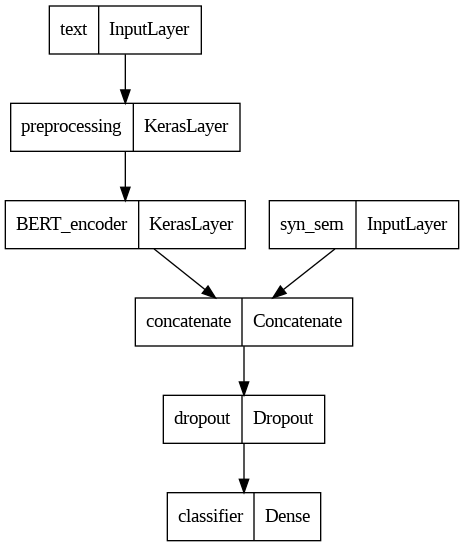

In [27]:
tf.keras.utils.plot_model(classifier_model)

## Defining loss fn and metrics

In [28]:
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
metrics = [tfa.metrics.F1Score(num_classes=4, average='macro'),
           tf.keras.metrics.CategoricalAccuracy(),
           tf.keras.metrics.Precision(name='precision'),
           tf.keras.metrics.Recall(name='recall'),
]

## Defining training parameters

In [30]:
batch_size = 32

epochs = 10
steps_per_epoch = len(X_train)
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5

print(f'''Setting up optimizer with the following parameters:     
     epochs={epochs}
     steps_per_epoch={steps_per_epoch}
     num_train_steps={num_train_steps}
     num_warmup_steps={num_warmup_steps}
     init_lr={init_lr}''')
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

Setting up optimizer with the following parameters:     
     epochs=1
     steps_per_epoch=39083
     num_train_steps=39083
     num_warmup_steps=3908
     init_lr=3e-05


In [31]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

## Creating checkpoints to save model as it gets trained (optional but allows loading back the trained weights later)

In [34]:
path_checkpoint = "training_test/cp.ckpt"
directory_checkpoint = os.path.dirname(path_checkpoint)
callback = tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                              save_weights_only=True,
                                              verbose=1)

## This cell is only for loading in saved models. Normally no need to run

In [33]:
# classifier_model.load_weights(path_checkpoint)

In [35]:
print(f'Starting training for {epochs} epochs...')
if use_syn_sem:
  # only syn sem data, no text
  history = classifier_model.fit(X_train_extracted_features, y_train, batch_size=batch_size, epochs=epochs, callbacks=[callback])
elif use_syn_sem_with_text:
  # uncleaned text and syn sem data
  history = classifier_model.fit([X_train_text, X_train_extracted_features], y_train, batch_size=batch_size, epochs=epochs, callbacks=[callback])
elif use_syn_sem_with_cleaned_text:
  # cleaned text and syn sem data
  history = classifier_model.fit([X_train_text_cleaned, X_train_extracted_features], y_train, batch_size=batch_size, epochs=epochs, callbacks=[callback])
else:
  history = classifier_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[callback])

Starting training for 1 epochs...
1222/1222 [==============================] - ETA: 0s - loss: 0.6384 - f1_score: 0.9697 - categorical_accuracy: 0.9734 - precision: 0.9741 - recall: 0.9732
Epoch 1: saving model to training_small_test/cp.ckpt
1222/1222 [==============================] - 313s 248ms/step - loss: 0.6384 - f1_score: 0.9697 - categorical_accuracy: 0.9734 - precision: 0.9741 - recall: 0.9732


## Evaluating the model

In [36]:
test_results = classifier_model.evaluate([X_test_text_cleaned, X_test_extracted_features], y_test)

for i in range(len(classifier_model.metrics_names)):
  print(f'{classifier_model.metrics_names[i]}: {test_results[i]}')

306/306 [==============================] - 43s 137ms/step - loss: 0.4980 - f1_score: 0.9723 - categorical_accuracy: 0.9739 - precision: 0.9739 - recall: 0.9739
loss: 0.49796321988105774
f1_score: 0.9722669720649719
categorical_accuracy: 0.9739023447036743
precision: 0.9739023447036743
recall: 0.9739023447036743


### Plot training metrics over epochs

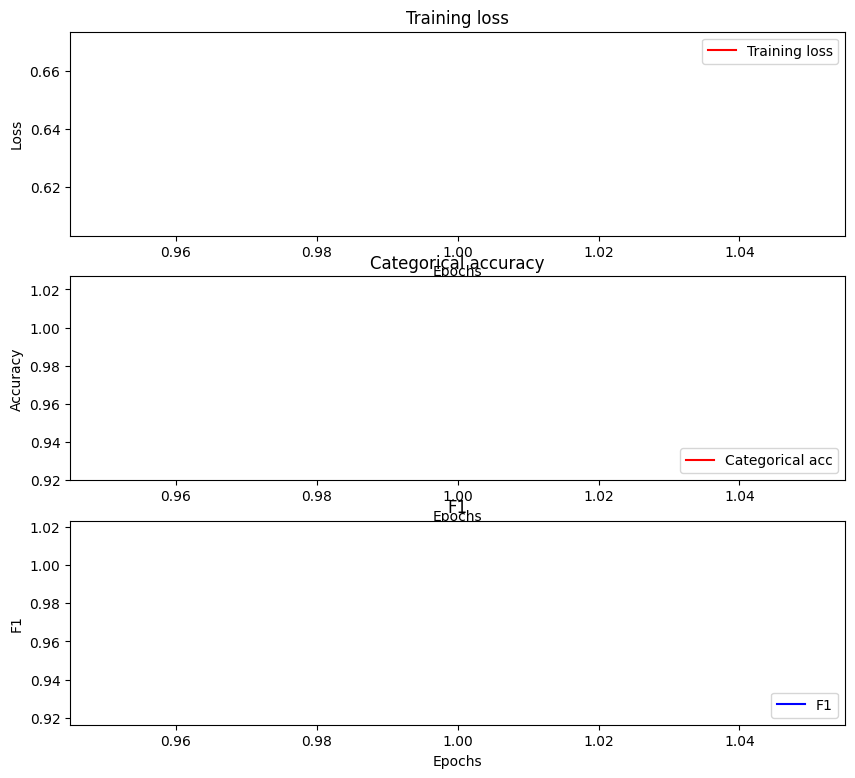

In [41]:
history_dict = history.history

cat_acc = history_dict['categorical_accuracy']
f1 = history_dict['f1_score']
loss = history_dict['loss']

epochs = range(1, len(cat_acc) + 1)
fig = plt.figure(figsize=(10, 9))
fig.tight_layout()

plt.subplot(3, 1, 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(epochs, cat_acc, 'r', label='Categorical acc')
plt.title('Categorical accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(3, 1, 3)
plt.plot(epochs, f1, 'b', label='F1')
plt.title('F1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')

### Getting metrics for comparison
* Micro
  * F1
* Macro
  * Precision
  * Recall
  * F1

In [42]:
y_pred = classifier_model.predict([X_test_text_cleaned, X_test_extracted_features])

306/306 [==============================] - 48s 154ms/step


In [47]:
y_pred_one_hot = tf.one_hot(tf.argmax(y_pred, axis=1), depth=4)

In [49]:
from sklearn.metrics import f1_score, precision_score, recall_score
micro_f1 = f1_score(y_test, y_pred_one_hot, average='micro')
macro_precision = precision_score(y_test, y_pred_one_hot, average='macro')
macro_recall = recall_score(y_test, y_pred_one_hot, average='macro')
macro_f1 = f1_score(y_test, y_pred_one_hot, average='macro')

In [50]:
print(f'micro_f1: {micro_f1}')
print(f'macro_precision: {macro_precision}')
print(f'macro_recall: {macro_recall}')
print(f'macro_f1: {macro_f1}')

micro_f1: 0.9739023641387781
macro_precision: 0.973548662772735
macro_recall: 0.9711547760345778
macro_f1: 0.9722669887338247


# Evaluating with `balancedtest.csv`

In [ ]:
test_set_df = pd.read_pickle("test.pkl")

## Removing all the unnecessary columns not in the train_df

In [ ]:
for col in test_set_df.columns:
  if col not in df_train.columns and col != 'Label':
    test_set_df.pop(col)

In [ ]:
test_set_df.dtypes

Label                           int64
Text                           object
Text_Clean                     object
Char_Count                      int64
Word_Count                      int64
Capital_Chars_Count             int64
Capital_Words_Count             int64
First_Person_Pronoun_Count      int64
Second_Person_Pronoun_Count     int64
Third_Person_Pronoun_Count      int64
Boost_Count                     int64
Number_Count                    int64
Positive_Word_Count             int64
Negative_Word_Count             int64
Proper_Noun_Count               int64
Conjunction_Count               int64
Superlative_Count               int64
dtype: object

In [ ]:
if use_syn_sem or use_syn_sem_with_text or use_syn_sem_with_cleaned_text:
  X_test_set, y_test_set = convert_df_to_Xy(test_set_df, target_name='Label')

  # 'Text' column
  X_test_set_text = X_test_set[:, :1]
  # 'Text_Clean' column
  X_test_set_text_cleaned = X_test_set[:, 1:2]
  # All the remaining columns
  X_test_set_extracted_features = X_test_set[:, 2:]
  # Converting from 'Object' to their respective types
  X_test_set_text = np.asarray(X_test_set_text).astype('object')
  X_test_set_text_cleaned = np.asarray(X_test_set_text_cleaned).astype('object')
  X_test_set_extracted_features = np.asarray(X_test_set_extracted_features).astype('float32')
else:
  X_test_set, y_test_set = convert_df_to_Xy(test_set_df, target_name='label')

In [ ]:
test_set_results = classifier_model.evaluate([X_test_set_text_cleaned, X_test_set_extracted_features], y_test_set)

for i in range(len(classifier_model.metrics_names)):
  print(f'{classifier_model.metrics_names[i]}: {test_set_results[i]}')

94/94 [==============================] - 13s 135ms/step - loss: 18.0747 - f1_score: 0.6092 - categorical_accuracy: 0.6257 - tp: 1877.0000 - fp: 1123.0000 - tn: 7877.0000 - fn: 1123.0000 - precision: 0.6257 - recall: 0.6257 - auc: 0.7629 - prc: 0.5510
loss: 18.074668884277344
f1_score: [0.71803653 0.5740433  0.4241037  0.720461  ]
categorical_accuracy: 0.6256666779518127
tp: 1877.0
fp: 1123.0
tn: 7877.0
fn: 1123.0
precision: 0.6256666779518127
recall: 0.6256666779518127
auc: 0.7629457116127014
prc: 0.5509698390960693
